# AIA Data introduction

## AIA filters
<img src='int_pap/wave_ion_region_temp.png' >

## AIA instrument characteristics
<img src="int_pap/int_table.png">

### Sampling    
Notice the resolution (1.5 arcsec) of the telescope is different from the pixel size (0.6 arcsec). This is on purpose as pixel size should never equal the resolution. In fact, the resolution should be 2.5 to the pixel size satisfy the Nyquist sampling criterion.  

In [160]:
#Example of Spectral Observation
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np


In [161]:
#add tick marks to plots
def fancy_plot(ax):
    """
    Parameters
    ----------
    ax: Axis object
        Axis object you would like nice tick marks on
    Returns
    -------
    ax: Axis object with nice tick marks
    """
    #Turn minor ticks on
    ax.minorticks_on()
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3,direction='in')
    ax.tick_params(direction='in')
    return ax

In [162]:
#Unnormalized black body function without physical units
def bb(lam,T=5777):
    """
    Parameters
    -----------
    lam: np.array
        Wavelength of light in Angstroms
    T: float, optional
        Temperature of blackbody object in Kelvin (default = 5777, solar photosphere)
    Returns
    -------
    Array containing unnormalized blackbody shape
    """
    #hc = 12400 eV*Angstroms
    hc = 12400.
    k = 8.6173303E-5 #Boltzmann constant in eV K-1
    kT = k*T #eV
    return (lam**(-5))*(np.exp(hc/(lam*kT))-1.)**(-1)

In [163]:
#Set up some initial variables
#Wavelength
wave = np.linspace(100,350,100000) #Angstroms

#Continuum Intensity assuming a blackbody shape
cont = bb(wave)
#normalize peak to 1
cont /= cont.max()


<IPython.core.display.Javascript object>


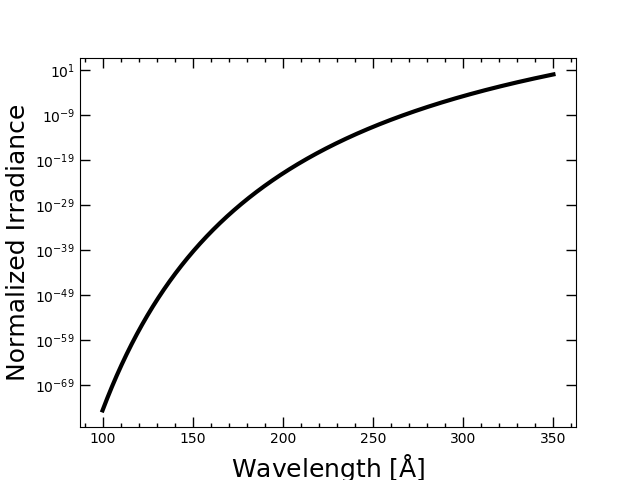

In [164]:
#Plot the blackbody we just created
fig, ax = plt.subplots()

#Plot a line
ax.plot(wave,cont,color='black',linewidth=3)

#Label and tidy up plot
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax.set_ylabel('Normalized Irradiance',fontsize=18)
ax.set_yscale('log')
fancy_plot(ax)

In [112]:
#Fucntion to create a gaussian
def gauss(wav,a,b,c):
    """
    Parameters
    ----------
    wave: np.array
        Array of input wavelengths
    a: float
        Height of input Gaussian
    b: float
        Centeral wavelength of input Gaussian
    c: float
        Sigma squared of input Gaussian
   
    Returns
    -------
    Gaussian values for input parameters
    """
    return a*np.exp(-((wav-b)**2/(2.*c**2)))

In [171]:
#Create Gaussian Fe XII line to add to continuum 
#There is a lot of line physics I am skipping here. Instead I am just making line strengths 
fexii = gauss(wave,.2,193.5,0.5)
#Create Gaussian Fe XXIV line to add to continuum
fexxiv = gauss(wave,.1,192.0,0.3)

<IPython.core.display.Javascript object>


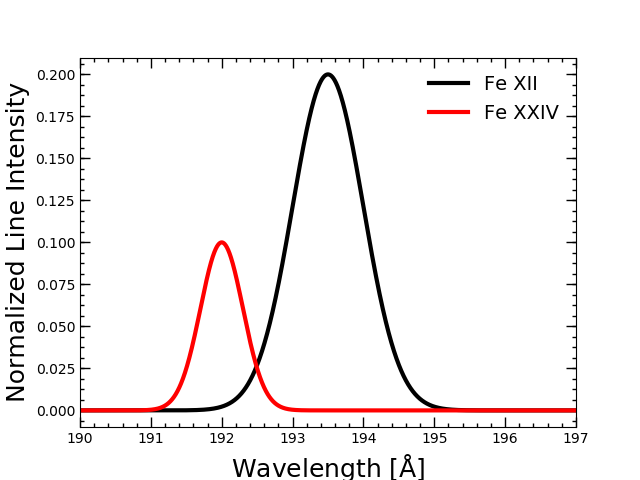

In [172]:
#Plot the lines we just created
fig, ax = plt.subplots()

#Plot Fe XII line
ax.plot(wave,fexii,color='black',linewidth=3,label='Fe XII') 
#Plot Fe XXIV line
ax.plot(wave,fexxiv,color='red',linewidth=3,label='Fe XXIV')


#Label and tidy up plot
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax.set_ylabel('Normalized Line Intensity',fontsize=18)
fancy_plot(ax)

#set plot in restricted range
ax.set_xlim([190.,197.])

#Add legend
ax.legend(loc='upper right',frameon=False,fontsize=14)


<IPython.core.display.Javascript object>


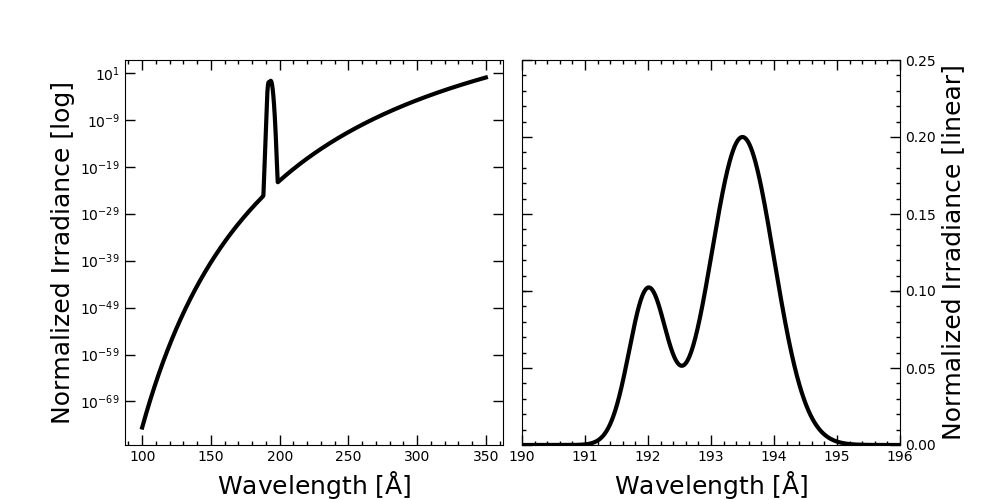

In [170]:
#Create a sudo spectrum by scaling the Fe lines and adding to the continuum
sudo_spec = (fexii+fexxiv)*(1.+cont)+cont
#Plot the spectrum we just created
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
fig.subplots_adjust(wspace=0.05)

#Create two column plot
ax[0].plot(wave,sudo_spec,color='black',linewidth=3)
ax[1].plot(wave,sudo_spec,color='black',linewidth=3)


#set plot in restricted range
ax[1].set_xlim([190.,196.])
ax[1].set_ylim([0,0.25])

#Label and tidy up plot
ax[1].set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax[1].set_ylabel('Normalized Irradiance [linear]',fontsize=18)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

fancy_plot(ax[1])
ax[0].set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax[0].set_ylabel('Normalized Irradiance [log]',fontsize=18)
ax[0].set_yscale('log')
fancy_plot(ax[0])

## Imaging Observed Spectrum
It is difficult to get large field of view (FoV) high wavelength resolution spectra, large FoV high spatial resolution imaging, and high time resolution observations simultaneously. SDO/AIA decided to focus on the latter two.  

### Spectral Resolution
Spectral resolution allows you to differentiate between spectral lines and better understand the physics you are observing. In the above plot you should note that the Fe XII and Fe XXIV lines overlap a bit. This is called line blending. Blending makes it difficult to isolate a line and understand the physics that produced the line. As you go to lower and lower resolutions more lines become blended. Imaging is effectively very low resolution spectra. Below is a quick example showing how blending effects line measurements.

<IPython.core.display.Javascript object>


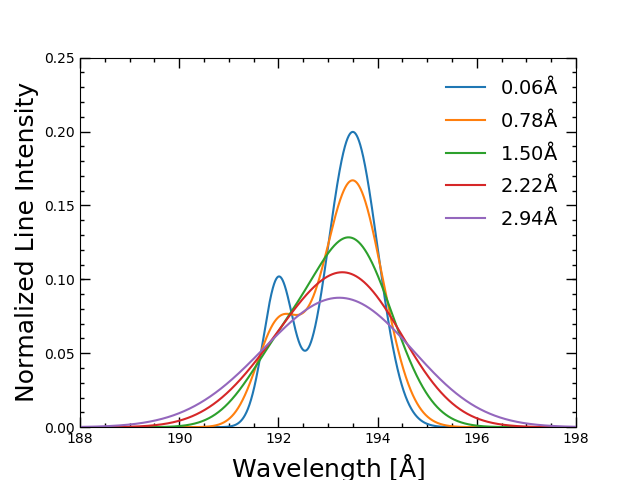

In [188]:
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.modeling import models, fitting

fig, ax = plt.subplots()

#wavelength per pixel
pix_wav = wave[1]-wave[0]

#Quote resolution as a FWHM
fwhm_sig = 2.355

#label format
lab_fmt = '{0:3.2f}'
for i in np.linspace(10,500,5):
    #Create a lower resolution kernal
    g = Gaussian1DKernel(i)
    #Convolve the kernal with the "observed" spectrum
    conv_spec = convolve(sudo_spec,g,boundary='extend')
    #plot the convolved spectrum
    ax.plot(wave,conv_spec,label=lab_fmt.format(i*pix_wav*fwhm_sig)+'$\mathrm{\AA}$')
    

#Label and tidy up plot
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax.set_ylabel('Normalized Line Intensity',fontsize=18)
fancy_plot(ax)

#set plot in restricted range
ax.set_xlim([188.,198.])
ax.set_ylim([0,0.25])

#Add legend
ax.legend(loc='upper right',frameon=False,fontsize=14)


## References
[The Atmospheric Imaging Assembly (AIA) on the Solar Dynamics Observatory (SDO)](https://ui.adsabs.harvard.edu/#abs/2012SoPh..275...17L/abstract)